## Data Preparation

Mempersiapkan dan memastikan bahwa data yang digunakan untuk analisis adalah data yang berkualitas dan dapat digunakan untuk modelling

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

df = pd.read_csv('train.csv', sep = ';')
df.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
25311,35,technician,married,tertiary,no,14232,yes,no,cellular,18,nov,372,2,-1,0,unknown,no
17223,33,management,married,tertiary,no,0,yes,no,cellular,28,jul,54,3,-1,0,unknown,no
39134,39,blue-collar,married,secondary,no,161,yes,no,cellular,18,may,98,2,-1,0,unknown,no
44498,32,technician,married,secondary,no,473,no,yes,cellular,10,aug,1064,1,95,3,success,yes
34974,28,admin.,single,secondary,no,177,yes,yes,cellular,6,may,150,1,-1,0,unknown,no


In [8]:
cats = df.select_dtypes(include = ['object']).columns
nums = df.select_dtypes(include = ['int64', 'float64']).columns

cats, nums

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'poutcome', 'y'],
       dtype='object'),
 Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'))

### Missing Values

In [4]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Tidak perlu handling missing values, dikarenakan tidak ada kolom yang null

### Duplicate Values

In [6]:
df.duplicated().any()

False

Tidak perlu handling duplicated values di karenakan tidak ada value duplikat

### Penanganan Outliers 

Kami mempertimbangkan untuk  penanganan outliers menggunakan Z-score untuk menentukan seberapa jauh suatu data berada dari rata-rata, dengan Z-score tinggi dianggap sebagai outlier atau nilai ekstrem , kami mempertimbangkan dengan memilih z-score dikarenakan kami tidak ingin kehilangan banyak data. Dikarenakan data nya tidak berdistribusi normal maka kami melakukan log transformasi terlebih dahulu.

In [9]:
for i in nums:
    if (df[i] < 0).any():
        df[i] = df.apply(lambda x : int(0) if int(x[i]) < 0 else x[i], axis = 1)
    print(f"Total negative value of {i}:", (df[i] < 0).sum())

Total negative value of age: 0
Total negative value of balance: 0
Total negative value of day: 0
Total negative value of duration: 0
Total negative value of campaign: 0
Total negative value of pdays: 0
Total negative value of previous: 0


Sebelum melakukan log transformasi, dicek terlebih dahulu agar tidak ada negatif values ketika log transformasi

In [187]:
# df = df[df['education'] != 'unknown']

In [10]:
for i in nums:
    if i not in ['age', 'day']:
        df[i] = np.log(df[i] + (df[df[i] > 0][i].min() / 2))

In [11]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,5.199427,15.806419,5.167016,0.963267,0.389388,-0.373537
std,10.618762,3.007085,8.322476,0.927908,0.590519,2.311494,0.727591
min,18.000000,-0.693147,1.000000,-0.693147,0.405465,-0.693147,-0.693147
25%,33.000000,4.283587,8.000000,4.639572,0.405465,-0.693147,-0.693147
50%,39.000000,6.105909,16.000000,5.195731,0.916291,-0.693147,-0.693147
75%,48.000000,7.264380,21.000000,5.766757,1.252763,-0.693147,-0.693147
max,95.000000,11.533977,31.000000,8.500759,4.151040,6.770216,5.618588


Terlihat dari `df.describe()` bahwa data sudah berdistribusi normal

In [12]:
from scipy import stats

print("Before removing outlier: ", len(df))

for i in nums:
    if i not in ['age', 'day']:
        z_scores = np.abs(stats.zscore(df[i]))
        df = df[z_scores <= 3]

print("After removing outlier: ", len(df))

Before removing outlier:  45211
After removing outlier:  43173


Setelah removing outlier dengan zscore terdapat 2.038 data yang di remove

### Normalization Transformation

Seebelum dilakukan scalling dengan normalization, data perlu di split terlebih dahulu, menjadi train dan test

In [13]:
X = df.drop(columns=['y'])
y = df[['y']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for i in list(X_train.select_dtypes(include = ['int64', 'float64']).columns):
    fitted = scaler.fit(X_train[[i]])
    X_train[i] = fitted.transform(X_train[[i]])
    X_test[i] = fitted.transform(X_test[[i]])

In [15]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

train = train[train['education'] != 'unknown']
test = test[test['education'] != 'unknown']

X_train = train.drop(columns=['y'])
y_train = train[['y']]

X_test = test.drop(columns=['y'])
y_test = test[['y']]

### Lable Encoding & One Hot Encoding

Fitur-fitur kategorikal perlu di-encode menjadi representasi numerik agar dapat digunakan dalam model. dengan label encoding pada kolom `married`,`education`, `default`, `housing`, `loan` dan `month`. untuk kolom month di jadikan 4 kuartal menjadi 'month quarter'
dan one hot encoding untuk kolom `job`, `contact` dan `month quarter`

In [16]:
X_train['is_married'] = X_train['marital'].apply(lambda x : 1 if x == 'married' else 0)

X_test['is_married'] = X_test['marital'].apply(lambda x : 1 if x == 'married' else 0)

X_train['education_mapped'] = X_train['education'].map({'primary' : 0,
                                                        'secondary' : 1,
                                                        'tertiary' : 2})

X_test['education_mapped'] = X_test['education'].map({'primary' : 0,
                                                      'secondary' : 1,
                                                      'tertiary' : 2})

X_train['is_default'] = X_train['default'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_default'] = X_test['default'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_housing'] = X_train['housing'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_housing'] = X_test['housing'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_loan'] = X_train['loan'].map({'no' : 0,
                                          'yes' : 1})

X_test['is_loan'] = X_test['loan'].map({'no' : 0,
                                        'yes' : 1})

X_train['month_quarter'] = X_train['month'].apply(lambda x : 'first' if x in ['jan', 'feb', 'mar'] else 'second'\
                                                                     if x in ['apr', 'may', 'jun'] else 'third'\
                                                                     if x in ['jul', 'aug', 'sep'] else 'fourth')

X_test['month_quarter'] = X_test['month'].apply(lambda x : 'first' if x in ['jan', 'feb', 'mar'] else 'second'\
                                                                   if x in ['apr', 'may', 'jun'] else 'third'\
                                                                   if x in ['jul', 'aug', 'sep'] else 'fourth')

X_train['is_poutcome_succcess'] = X_train['poutcome'].apply(lambda x : 1 if x == 'success' else 0)

X_test['is_poutcome_succcess'] = X_test['poutcome'].apply(lambda x : 1 if x == 'success' else 0)

y_train['y'] = y_train['y'].map({'no' : 0,
                                 'yes' : 1})

y_test['y'] = y_test['y'].map({'no' : 0,
                               'yes' : 1})

In [17]:
for i in ['job', 'contact', 'month_quarter']:
    X_train = pd.concat([X_train, pd.get_dummies(X_train[i], prefix = i)], axis = 1)
    X_test = pd.concat([X_test, pd.get_dummies(X_test[i], prefix = i)], axis = 1)

In [18]:
X_train = X_train.drop(columns = list(X_train.select_dtypes(include = ['object']).columns) + ['month_quarter'])
X_test = X_test.drop(columns = list(X_test.select_dtypes(include = ['object']).columns) + ['month_quarter'])

In [19]:
col = ['age', 'balance', 'is_married', 'education_mapped', 'is_default', 'is_housing', 'is_loan', 'job_admin.',\
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',\
       'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown']

X_train = X_train.drop(columns = [i for i in X_train.columns if i not in col])
X_test = X_test.drop(columns = [i for i in X_test.columns if i not in col])

In [20]:
X_train.columns, len(X_train.columns)

(Index(['age', 'balance', 'is_married', 'education_mapped', 'is_default',
        'is_housing', 'is_loan', 'job_admin.', 'job_blue-collar',
        'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
        'job_self-employed', 'job_services', 'job_student', 'job_technician',
        'job_unemployed', 'job_unknown'],
       dtype='object'),
 19)

### Class Imbalance

Dikarenakan fitur target 'y' itu memiliki data imbalance maka kami mempertimbangkan untuk handling class imbalance dengan SMOTE

In [185]:
from imblearn import over_sampling

X_train_over, y_train_over = over_sampling.SMOTE(sampling_strategy = 0.5).fit_resample(X_train, y_train)

In [186]:
pd.concat([X_train, y_train], axis = 1).duplicated().sum()

3014

In [187]:
pd.concat([X_test, y_test], axis = 1).duplicated().sum()

741

In [188]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

train = train.drop_duplicates()
test = test.drop_duplicates()

X_train = train.drop(columns=['y'])
y_train = train[['y']]

X_test = test.drop(columns=['y'])
y_test = test[['y']]

(-3.95, 104.95, -0.010874824635684585, 0.22837131734937627)

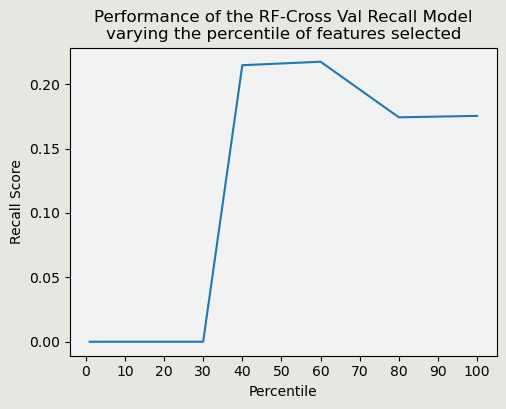

In [96]:
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = Pipeline(
    [
        ("picker", SelectPercentile()),
        ("rf", RandomForestClassifier()),
    ]
)

score_means = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(picker__percentile=percentile)
    this_scores = cross_val_score(clf, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), scoring = 'recall')
    score_means.append(this_scores.mean())

plt.figure(figsize = (5.5, 4), facecolor='#e8e6e1')
ax = plt.axes()
ax.set_facecolor('#f1f2f2')
plt.plot(percentiles, score_means)
plt.title("Performance of the RF-Cross Val Recall Model\nvarying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Recall Score")
plt.axis("tight")

Text(0.5, 1.0, 'Recursive Feature Elimination \nwith correlated features')

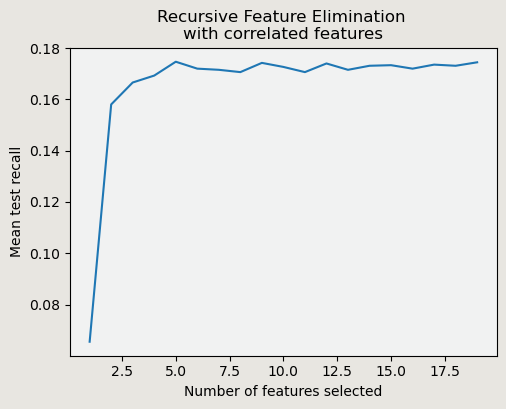

In [189]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1
clf = RandomForestClassifier()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="recall",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
rfecv.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure(figsize = (5.5, 4), facecolor='#e8e6e1')
ax = plt.axes()
ax.set_facecolor('#f1f2f2')
plt.xlabel("Number of features selected")
plt.ylabel("Mean test recall")
plt.plot(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"]
)
plt.title("Recursive Feature Elimination \nwith correlated features")

# print(f"Optimal number of features: {rfecv.n_features_}")

Berdasarkan hasil validasi model menggunakan filter method yang mengukur mean recall scoring parameter pada beberapa persentase fitur yang terlibat dalam proses pembentukan model diperoleh kondisi optimal dengan memanfaatkan percentile 60 dari fitur atau sekitar 11 fitur dari eksperimen yang berjumlah 19 fitur. Daftar fitur yang menjadi bahan pertimbangan adalah age, balance, is_married, education_mapped, is_default, is_housing, job, is_poutcome_success, duration, campaign, pdays

Metode Recursive Feature Elimination berperan dalam menentukan jumlah fitur penyusun model melalui penghapusan/eliminasi fitur yang memiliki nilai koefisien terendah secara iteratif untuk seluruh kombinasi fitur yang tersedia guna memperoleh nilai mean test recall yang paling optimal. Mengacu pada grafik, kondisi ideal mampu mengakomodasi sekitar 8 fitur yaitu age, balance, is_married, education_mapped, is_default, is_housing, is_loan dan job

Merujuk pada kedua metode yang mampu merekomendasikan fitur pembentuk model, maka ditentukan fitur yang berkontribusi terhadap predictor yaitu age, balance, is_married, education_mapped, is_default, is_housing, is_loan dan job

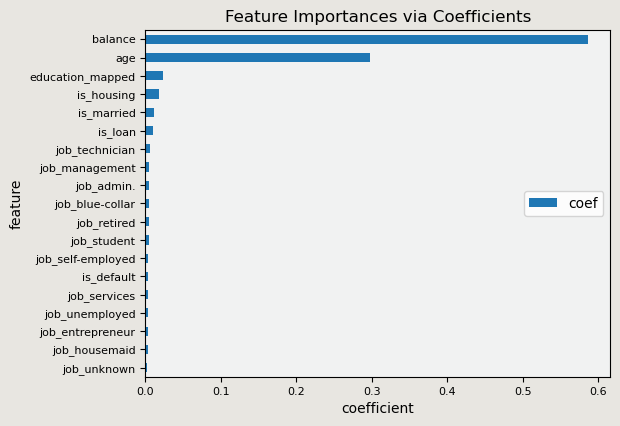

In [190]:
clf = RandomForestClassifier().fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))
importance = np.abs(clf.feature_importances_)
feature_names = np.array(X_train.columns)
plt.figure(figsize = (6, 4.5), facecolor='#e8e6e1')
ax = plt.axes()
ax.set_facecolor('#f1f2f2')
pd.DataFrame(list(zip(list(X_train.columns), clf.feature_importances_)), columns = ['feature', 'coef'])\
            .sort_values(by = ['coef'], ascending = True).reset_index(drop = True)\
            .plot(x = 'feature', kind = 'barh', fontsize = 8, ax = ax)
plt.title("Feature Importances via Coefficients")
plt.xlabel('coefficient')
plt.legend(loc = 'center right')

In [385]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

def eval_classification():
    n_estimators = [int(x) for x in np.linspace(1, 200, 50)]
    criterion = ['gini', 'entropy']
    max_depth = [int(x) for x in np.linspace(2, 100, 50)]
    min_samples_split = [int(x) for x in np.linspace(2, 20, 10)]
    min_samples_leaf = [int(x) for x in np.linspace(2, 20, 10)]
    
    hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                           min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    list_model = {'Logistic Regression' : LogisticRegression(),
                  'KNN Classifier' : KNeighborsClassifier(),
                  'Decision Tree Classifier' : DecisionTreeClassifier(),
                  'Random Forest Classifier' : RandomForestClassifier(),
                  'AdaBoost Classifier' : AdaBoostClassifier(),
                  'XGBoost Classifier' : XGBClassifier(),
                  'LGBM Classifier' : LGBMClassifier()}
    
    for key, val in list_model.items():
        model = val
        model.fit(X_train_over, y_train_over)
    
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        y_pred_proba = model.predict_proba(X_test)
        y_pred_proba_train = model.predict_proba(X_train)

        print(key, "Evaluation Result")
        print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
        print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
        print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
        print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
        print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
        print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
        print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
        print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

        print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
        print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
        print("")

In [386]:
eval_classification()

Logistic Regression Evaluation Result
Accuracy (Train Set): 0.87
Accuracy (Test Set): 0.86
Precision (Train Set): 0.46
Precision (Test Set): 0.42
Recall (Train Set): 0.68
Recall (Test Set): 0.66
F1-Score (Train Set): 0.55
F1-Score (Test Set): 0.52
roc_auc (train-proba): 0.89
roc_auc (test-proba): 0.89

KNN Classifier Evaluation Result
Accuracy (Train Set): 0.91
Accuracy (Test Set): 0.83
Precision (Train Set): 0.56
Precision (Test Set): 0.34
Recall (Train Set): 0.87
Recall (Test Set): 0.52
F1-Score (Train Set): 0.68
F1-Score (Test Set): 0.41
roc_auc (train-proba): 0.97
roc_auc (test-proba): 0.78

Decision Tree Classifier Evaluation Result
Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.86
Precision (Train Set): 1.00
Precision (Test Set): 0.40
Recall (Train Set): 1.00
Recall (Test Set): 0.53
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.46
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.72

Random Forest Classifier Evaluation Result
Accuracy (Train Set): 1.00
Accuracy (Test Set